In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from sklearn.model_selection import train_test_split

1. user_questions  데이터 이해와 전처리

1) 데이터 로드하기

In [142]:
user_q = pd.read_csv('./user_questions.csv')
user_q.head()

,Question,Predicted_Label,Column1
0,안녕?,2.0,NaN
1,날씨,2.0,NaN
2,오늘의 날씨는?,2.0,NaN
3,대체 음란찜이 뭐야?,2.0,NaN
4,오늘 냉장고에 뭐가 있을가,2.0,NaN


In [143]:
user_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Question         422 non-null    object 
 1   Predicted_Label  417 non-null    float64
 2   Column1          407 non-null    object 
dtypes: float64(1), object(2)
memory usage: 10.0+ KB


In [144]:
# 'Predicted_Label'열의 null값 삭제하기
user_q = user_q.dropna(subset =['Predicted_Label'])

In [145]:
user_q = user_q[['Question','Predicted_Label']]
user_q.head()

,Question,Predicted_Label
0,안녕?,2.0
1,날씨,2.0
2,오늘의 날씨는?,2.0
3,대체 음란찜이 뭐야?,2.0
4,오늘 냉장고에 뭐가 있을가,2.0


In [146]:
# 'Predicted_Label'열의 값을 int로 변경하기
user_q['Predicted_Label'] = user_q['Predicted_Label'].apply(int)

In [147]:
# 훈련데이터와 테스트 데이터로 나누기 (총 471개에서 훈련은 317개, 테스트는 100개로 임의로 나누기)
# 데이터의 인덱스 섞기
indices = np.random.permutation(len(user_q))



In [148]:
train_indices = indices[:317]
train_data = user_q.iloc[train_indices]

In [149]:
test_indices = indices[317:]
test_data = user_q.iloc[test_indices]

In [150]:
# train_dta에 존재하는 질문 갯수 확인
print('훈련용 질문 개수 :', len(train_data))

훈련용 질문 개수 : 317


In [151]:
train_data.head()

,Question,Predicted_Label
116,안녕?,2
294,"햄 150g, 프랑크소시지 2개",0
148,레시피,1
189,안녕?,2
261,셀러리 대파 청양고추,1


In [152]:
print('테스트용 질문 개수: ', len(test_data))

테스트용 질문 개수:  100


In [153]:
test_data.head()

,Question,Predicted_Label
97,소고기 버섯 두부 계란,1
242,크림파스타 레시피 알려줘,1
106,그럼 닭고기 버섯 치즈는?,2
371,양배추가 들어가는 요리,0
17,낙지전골 레시피,0


2) 데이터 정제하기

In [154]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['Question'].nunique(), train_data['Predicted_Label'].nunique()

(299, 4)

In [155]:
# 중복 샘플 제거하기
train_data.drop_duplicates(subset=['Question'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\407243521.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(subset=['Question'], inplace=True)


In [156]:
len(train_data)

299

<Axes: xlabel='Predicted_Label'>

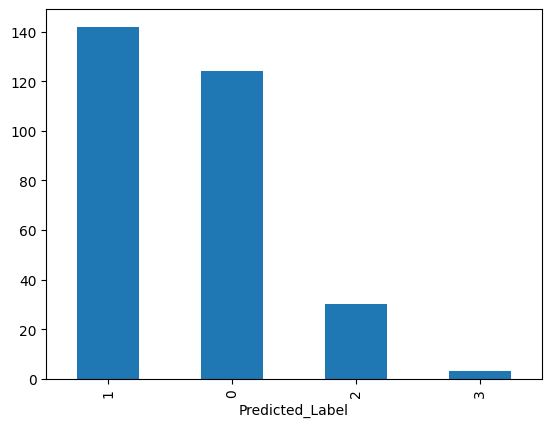

In [157]:
# 분류 레이블 값 분포 확인
train_data['Predicted_Label'].value_counts().plot(kind='bar')

In [158]:
print(train_data.groupby('Predicted_Label').size().reset_index(name='count'))

   Predicted_Label  count
0                0    124
1                1    142
2                2     30
3                3      3


In [159]:
# null값 확인하기
train_data.isnull().sum()

Question           0
Predicted_Label    0
dtype: int64

In [160]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 116 to 366
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Question         299 non-null    object
 1   Predicted_Label  299 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB


In [161]:
# 전처리 _ 특수문자 등 한글만 남기고 제거하기. 
# 정규 표현식 사용
train_data['Question'] = train_data['Question'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\3456497112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Question'] = train_data['Question'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


,Question,Predicted_Label
116,안녕,2
294,햄 프랑크소시지 개,0
148,레시피,1
261,셀러리 대파 청양고추,1
359,쪽파랑 맛술 팽이버섯,0


In [162]:
# Predicted_Label -> 0: 재료, 1:음식, 2: 기타, 3: 추천
train_data[train_data['Predicted_Label'] == 3]

,Question,Predicted_Label
390,양식 아무거나,3
396,일식 아무거나,3
196,한식 아무거나 추천해줘,3


In [163]:
# 공백만 있거나 빈값을 가진 행이 있다면 null값으로 변경하고 확인
train_data['Question'] = train_data['Question'].str.replace('^ +', "",regex=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\814723206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Question'] = train_data['Question'].str.replace('^ +', "",regex=True)


In [164]:
train_data['Question'].replace('', np.nan, inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\4245464829.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Question'].replace('', np.nan, inplace=True)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\4245464829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Question'].replace('', np.nan, inplace=True)


In [165]:
print(train_data.isnull().sum())

Question           0
Predicted_Label    0
dtype: int64


In [166]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 116 to 366
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Question         299 non-null    object
 1   Predicted_Label  299 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ KB


In [167]:
#  테스트 데이터 전처리
test_data.drop_duplicates(subset=['Question'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\2144666940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset=['Question'], inplace=True)


In [168]:
test_data['Question'] = test_data['Question'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\1658432767.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Question'] = test_data['Question'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


In [169]:
test_data['Question'] = test_data['Question'].str.replace('^ +', "", regex= True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\799501050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Question'] = test_data['Question'].str.replace('^ +', "", regex= True)


In [170]:
test_data['Question'].replace('', np.nan, inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\3390892265.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Question'].replace('', np.nan, inplace=True)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_8064\3390892265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Question'].replace('', np.nan, inplace=True)


In [171]:
test_data = test_data.dropna(how= 'any')

In [172]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 97 to 255
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Question         99 non-null     object
 1   Predicted_Label  99 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


3)토큰화

In [173]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [174]:
# Okt를 사용하여 형태소 분석
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [175]:
# train_data 에 형태소 분석기를 사용하여 토큰화, 불용어 제거 후 X_train에 저장하기
# tqdm -> terminal 또는 notebook 자동으로 진행상태를 시각적으로 보여주는 라이브러리
X_train=[]
for sentence in tqdm(train_data['Question']):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 299/299 [00:00<00:00, 2187.35it/s]


In [176]:
X_train[:3]

[['안녕'], ['햄', '프랑크', '소시지', '개'], ['레시피']]

In [177]:
X_test = []
for sentence in tqdm(test_data['Question']):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 99/99 [00:00<00:00, 513.65it/s]


4) 정수인코딩

In [178]:
# 훈련데이터에 대해서 단어집합 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [179]:
# 단어집합 생성 및 각 단어에 고유 index 부여 확인
tokenizer.word_index

{'소고기': 1,
 '돼지고기': 2,
 '레시피': 3,
 '만들다': 4,
 '있다': 5,
 '음식': 6,
 '양파': 7,
 '들어가다': 8,
 '요리': 9,
 '두부': 10,
 '법': 11,
 '알다': 12,
 '어떻다': 13,
 '김치': 14,
 '버섯': 15,
 '뭐': 16,
 '로': 17,
 '먹다': 18,
 '마늘': 19,
 '대파': 20,
 '랑': 21,
 '냉장고': 22,
 '계란': 23,
 '오늘': 24,
 '간장': 25,
 '오징어': 26,
 '파스타': 27,
 '감자': 28,
 '김치전': 29,
 '추천': 30,
 '김치찌개': 31,
 '소금': 32,
 '깨소금': 33,
 '수': 34,
 '오이': 35,
 '밥': 36,
 '뭘': 37,
 '올리브': 38,
 '구이': 39,
 '아무': 40,
 '거나': 41,
 '알밥': 42,
 '갈비': 43,
 '고추': 44,
 '새우': 45,
 '해먹': 46,
 '콩나물': 47,
 '치즈': 48,
 '날씨': 49,
 '팽이버섯': 50,
 '토마토': 51,
 '오븐': 52,
 '해주다': 53,
 '물': 54,
 '장조림': 55,
 '참치': 56,
 '닭': 57,
 '참기름': 58,
 '방법': 59,
 '갈비찜': 60,
 '쇠고기': 61,
 '로는': 62,
 '파슬리': 63,
 '크림': 64,
 '골뱅이': 65,
 '비빔밥': 66,
 '을': 67,
 '시금치': 68,
 '닭고기': 69,
 '너': 70,
 '라면': 71,
 '자동차': 72,
 '무치다': 73,
 '싶다': 74,
 '배추': 75,
 '안녕': 76,
 '햄': 77,
 '셀러리': 78,
 '쪽파': 79,
 '우엉': 80,
 '피자': 81,
 '수육': 82,
 '다지다': 83,
 '파': 84,
 '고': 85,
 '간수': 86,
 '명': 87,
 '깻잎': 88,
 '삼겹살': 89,
 '고수': 90,

In [180]:
total_cnt = len(tokenizer.word_index)

In [181]:
#  단어 집합의 최대 크기 제한
#  0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt 
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 340


In [182]:
#  텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [183]:
X_train[:3]

[[76], [77, 103, 104, 167], [3]]

In [184]:
len(X_train)

299

In [185]:
# train_data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['Predicted_Label'])
y_test = np.array(test_data['Predicted_Label'])

In [186]:
len(y_train)

299

6) 패딩

질문의 최대 길이 :  10
질문의 평균 길이 :  3.4949832775919734


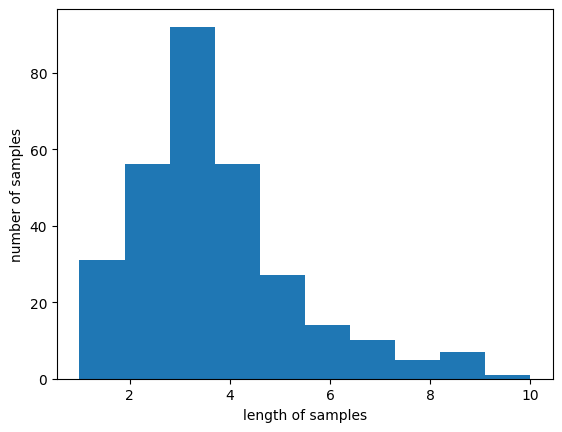

In [187]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업
print('질문의 최대 길이 : ', max(len(question) for question in X_train))
print('질문의 평균 길이 : ', sum(map(len, X_train)) / len(X_train))
plt.hist([len(question) for question in X_train], bins =10)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [188]:

# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율 확인
def below_threshold_len(max_len, nested_list):
    count =0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (count / len(nested_list))*100))

In [189]:
#  max_len을 8 이하인 샘플의 비율 확인
max_len =8
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 8 이하인 샘플의 비율 : 97.32441471571906


In [190]:
# 모든 샘플의 길이를 8로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

2. LSTM으로 질문 분류하기

#다중 클래스 분류 => 출력층에 로지스틱 회귀 사용. 

#활성화함수 : 소프트 맥스 함수, 손실함수 : 크로스 엔트로피함수

#하이퍼파라미터인 배치크기 : 64, 에포크 :15

#EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미 

#ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만모델을 저장

#validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인

#검증데이터는 기계가 훈련 데이터에 과적합 되고 있지는 않은지 확인하기 위한 용도로 사용됨.

In [191]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [194]:
from keras.utils import to_categorical

In [195]:
# 실제 레이블을 원-핫 인코딩
y_train_onehot = to_categorical(y_train, num_classes=4)

In [197]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(4, activation='softmax'))  # 출력층의 뉴런 수를 클래스 수로 설정

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])  # categorical_crossentropy 사용

# 실제 레이블을 원-핫 인코딩
y_train_encoded = to_categorical(y_train)

history = model.fit(X_train, y_train_encoded, epochs=100, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 2s 167ms/step - loss: 1.3236 - accuracy: 0.3515 - val_loss: 1.1714 - val_accuracy: 0.4833
Epoch 2/100
4/4 [==============================] - 0s 39ms/step - loss: 1.0473 - accuracy: 0.4728 - val_loss: 1.1100 - val_accuracy: 0.3833
Epoch 3/100
4/4 [==============================] - 0s 50ms/step - loss: 0.9856 - accuracy: 0.5230 - val_loss: 1.1010 - val_accuracy: 0.3833
Epoch 4/100
4/4 [==============================] - 0s 22ms/step - loss: 0.9448 - accuracy: 0.6192 - val_loss: 1.0764 - val_accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.9240 - accuracy: 0.6276 - val_loss: 1.0513 - val_accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 0s 16ms/step - loss: 0.9006 - accuracy: 0.6276 - val_loss: 1.1409 - val_accuracy: 0.3667
Epoch 7/100
4/4 [==============================] - 0s 18ms/step - loss: 0.8532 - accuracy: 0.6862 - val_loss: 1.2013 - val_accuracy: 0.3500
Epoch 8/100
4/4 [==

In [198]:
# 훈련 종료 후 테스트데이터에 대해서 정확도를 측정. 훈련과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5' 로드
loaded_model  = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

4/4 [==============================] - 0s 10ms/step - loss: 0.5268 - acc: 0.4141

 테스트 정확도: 0.4141


In [199]:
# 토크나이저 파일로 저장 후 로드
with open ('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

with open('tokenizer.pickle','rb') as handle:
    tokenizer = pickle.load(handle)

3. 리뷰 예측해보기

In [171]:
# 임의의 리뷰에 대해서 예측하는 함수 만들기
# 기본적으로 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용.
# model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 함

In [200]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',new_sentence)
    new_sentence = okt.morphs(new_sentence, stem = True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어제거

    encoded = tokenizer.texts_to_sequences([new_sentence])  # 정수 인코딩
    pad_new = pad_sequences (encoded, maxlen = max_len)  # 패딩

    predictions = loaded_model.predict(pad_new)  # 4개의 클래스에 대한 확률 예측

    print(f"Predictions shape: {predictions.shape}")

    # 가장 높은 확률을 가진 클래스 선택
    predicted_class = np.argmax(predictions, axis=1)[0]

    # 각 클래스에 대한 확률 출력
    class_names = ['재료', '음식', '기타', '추천']
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]*100:.2f}% 확률")
    
    print(f"\n예측된 클래스: {class_names[predicted_class]}")


In [201]:
sentiment_predict('김치찌개 어케 만들까')

1/1 [==============================] - 0s 306ms/step
Predictions shape: (1, 1)
재료: 100.00% 확률


IndexError: index 1 is out of bounds for axis 0 with size 1

In [130]:
sentiment_predict('감자로 만들수 있는 요리')

1/1 [==============================] - 0s 20ms/step
재료: 100.00% 확률


IndexError: index 1 is out of bounds for axis 0 with size 1

In [127]:
sentiment_predict('소고기')

1/1 [==============================] - 0s 15ms/step
재료: 100.00% 확률


IndexError: index 1 is out of bounds for axis 0 with size 1